# Processing and analyzing data from a stationary detector

This tutorial, demonstrates how to process and analyze neutron detection data from 3 Radiation Detection Technologies, Inc (RDT) neutron detectors using the Cosmic Ray Neutron Python (CRNPy) library. The tutorial covers steps including data loading, count data processing, normalization, outlier removal, atmospheric correction, and conversion of neutron counts to Volumetric Water Content (VWC). 

Firstly, import the required Python libraries, load the data from the [.csv file](https://raw.githubusercontent.com/soilwater/crnpy/main/docs/examples/stationary/rdt.csv). Converting the 'timestamp' column to datetime format is essential for time-based operations. Lastly, setting 'timestamp' as the DataFrame index simplifies the time series analysis.

In [1]:
# Import required libraries
import crnpy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Load observations from a stationary detector
filepath = "https://raw.githubusercontent.com/soilwater/crnpy/main/docs/examples/stationary/rdt.csv"

# Read the DataFrame
df = pd.read_csv(filepath, names=['timestamp','barometric_pressure_Avg','relative_humidity_Avg', 'air_temperature_Avg','DP','BattVolt','counts_1_Tot','counts_2_Tot','counts_3_Tot'])

# Parse timestamps
df['timestamp'] = pd.to_datetime(df['timestamp'])


Count times are computed from timestamp. If 'NaN' values are present, the [`fill_counts()`](../../../reference/#crnpy.crnpy.fill_counts) function will replace them. Recheck for 'NaN' values to confirm that they've been adequately filled.

In [3]:
# Get counting times
df['integration_time'] = crnpy.get_integration_time(timestamp_col=df['timestamp'])

# Check counts for nan values in the counts
print("detectors with nan:", [df['counts_1_Tot'].isna().any(),df['counts_2_Tot'].isna().any(),df['counts_3_Tot'].isna().any()])

# Fill nan values in detector 2
df[['counts_1_Tot','counts_2_Tot','counts_3_Tot']] = crnpy.fill_counts(df[['counts_1_Tot','counts_2_Tot','counts_3_Tot']], actual_integration_time=df['integration_time'])

# Check counts for nan values in the counts
print("detectors with nan:", [df['counts_1_Tot'].isna().any(),df['counts_2_Tot'].isna().any(),df['counts_3_Tot'].isna().any()])

df[['counts_1_Tot','counts_2_Tot','counts_3_Tot']].head()


detectors with nan: [False, True, False]
Using median count time as expected count time: 3600.0
detectors with nan: [False, False, False]


,counts_1_Tot,counts_2_Tot,counts_3_Tot
0,848,716.0,742
1,436,7200.0,796
2,389,396.0,354
3,820,786.0,714
4,844,707.0,734


Normalize the counts to counts per hour using the [`adjust_temporal_counts()`](../../../reference/#crnpy.crnpy.adjust_temporal_counts) function from the crnpy library.

In [4]:
# Normalize counts to counts/h
df[['counts_1_Tot','counts_2_Tot','counts_3_Tot']] = crnpy.adjust_temporal_counts(df[['counts_1_Tot','counts_2_Tot','counts_3_Tot']], nominal_integration_time=3600, actual_integration_time=df['integration_time'])

df[['counts_1_Tot','counts_2_Tot','counts_3_Tot']].head()


,counts_1_Tot,counts_2_Tot,counts_3_Tot
0,NaN,NaN,NaN
1,436.0,7200.0,796.0
2,778.0,792.0,708.0
3,820.0,786.0,714.0
4,844.0,707.0,734.0


Utilize the [`compute_total_raw_counts()`](../../../reference/#crnpy.crnpy.compute_total_raw_counts) function to calculate the total counts across all detectors. After calculating the total counts, outliers are discarded using the [`drop_outliers()`](../../../reference/#crnpy.crnpy.drop_outliers) function.

In [5]:
# Compute total cunts
df['total_raw_counts'] = crnpy.compute_total_raw_counts(df[['counts_1_Tot','counts_2_Tot','counts_3_Tot']], nan_strategy='average')

# Drop outliers
df['total_raw_counts'] = crnpy.drop_outliers(df['total_raw_counts'], min_counts=1500, max_counts=3500, window = 11)

# Fill outlier counts
df['total_raw_counts'] = crnpy.fill_counts(df['total_raw_counts'], actual_integration_time=df['integration_time'])


NaN values found. Replacing missing values with average of other detectors before summing.
Discarded counts below 1500: 1
Discarded counts above 3500: 119
Discarded 64 outliers using modified Z-score.
Using median count time as expected count time: 3600.0


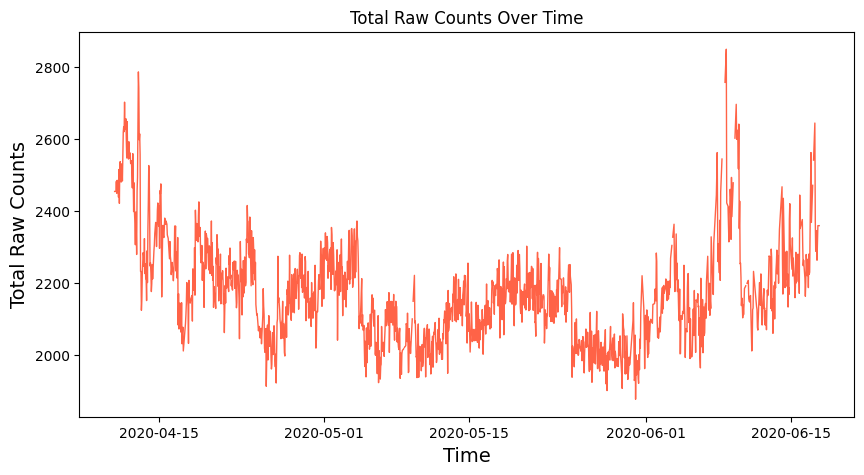

In [6]:
# Plot total counts
# Create a new figure and plot the data
fig, ax = plt.subplots(figsize=(10, 5))  # Set the figure size
ax.plot(df['timestamp'], df['total_raw_counts'], color='tomato', linewidth=1.0)

# Set the labels for the x-axis and y-axis
ax.set_xlabel("Time", fontsize=14)
ax.set_ylabel("Total Raw Counts", fontsize=14)

# Set the title of the plot
ax.set_title('Total Raw Counts Over Time')

# Show the plot
plt.show()

### Neutron count correction

#### Incomming neutron flux

Find similar stations based on cutoff rigidity, which is estimated using latitude and longitude values. See [`get_incoming_neutron_flux()`](../../../reference/#crnpy.crnpy.get_incoming_neutron_flux), [`find_neutron_monitor()`](../../../reference/#crnpy.crnpy.find_neutron_monitor) and [`incoming_flux_correction()`](../../../reference/#crnpy.crnpy.incoming_flux_correction). Note that the station is hardcoded in the second line as `station="IRKT"`. The user is required to manually define this after considering the potential options suggested.

In [7]:
# Define study start and end dates
start_date = df.iloc[0]['timestamp']
end_date = df.iloc[-1]['timestamp']

# Find stations with cutoff rigidity similar to estimated by lat,lon
crnpy.find_neutron_monitor(crnpy.cutoff_rigidity(39.1, -96.6), start_date=start_date, end_date=end_date)

# Download data for one of the similar stations and add to df. Using CST utc offset.
incoming_neutrons = crnpy.get_incoming_neutron_flux(start_date, end_date, station="IRKT", utc_offset=-5)

# Interpolate incoming neutron flux to match the timestamps in our station data
df['incoming_flux'] = crnpy.interpolate_incoming_flux(incoming_neutrons, timestamps=df['timestamp'])


# Compute correction factor for incoming neutron flux
df['fi'] = crnpy.incoming_flux_correction(incoming_neutrons=df['incoming_flux'],
                                                  incoming_Ref=incoming_neutrons.iloc[0])



Select a station with an altitude similar to that of your location. For more information go to: 'https://www.nmdb.eu/nest/help.php#helpstations

Your cutoff rigidity is 2.87 GV
     STID     NAME     R  Altitude_m  Period available
13   DRBS  Dourbes  3.18         225              True
40   NEWK   Newark  2.40          50              True
28  KIEL2   KielRT  2.36          54              True
21   IRKT  Irkustk  3.64         435              True


#### Atmospheric correction

This section is about correcting the atmospheric variables. First, fill the missing values in the atmospheric data, then correct the count for atmospheric variables using [`humidity_correction()`](../../../reference/#crnpy.crnpy.humidity_correction) and [`pressure_correction()`](../../../reference/#crnpy.crnpy.pressure_correction). 

In [8]:
# Fill NaN values in atmospheric data and neutron counts
df[['barometric_pressure_Avg','relative_humidity_Avg', 'air_temperature_Avg']] = crnpy.fill_missing_atm(df[['barometric_pressure_Avg', 'relative_humidity_Avg', 'air_temperature_Avg']])

# Compute the pressure correction factor 
df['fp'] = crnpy.pressure_correction(pressure=df['barometric_pressure_Avg'], Pref=df['barometric_pressure_Avg'].mean(), L=130)

# Calculate the absolute humidity (g cm^-3) and the vapor pressure correction factor
df['abs_humidity'] = crnpy.estimate_abs_humidity(df['relative_humidity_Avg'], df['air_temperature_Avg'])
df['fw'] = crnpy.humidity_correction(abs_humidity=df['abs_humidity'], Aref=0)


In [9]:
# Apply correction factors
df['total_corrected_neutrons'] = df['total_raw_counts'] * df['fw'] / (df['fp'] * df['fi'])


Convert the smoothed neutron counts to Volumetric Water Content (VWC) using the [`counts_to_vwc()`](../../../reference/#crnpy.crnpy.counts_to_vwc). The function considers the smoothed neutron counts, $N_0$ specific parameter, soil bulk density, weight percent of latent water (Wlat), and weight percent of soil organic carbon (Wsoc). After conversion, plot the VWC against the timestamp for visual analysis. [`smooth_1d()`](../../../reference/#crnpy.crnpy.smooth_1d) is pplied for smothing the data using a Savitzky-Golay filter.



In [10]:
# Device N0 parameter
N0_rdt = 3767 # Patrignani, A., Ochsner, T. E., Montag, B., & Bellinger, S. (2021). A novel lithium foil cosmic-ray neutron detector for measuring field-scale soil moisture. Frontiers in Water, 3, 673185.

# Estimate lattice water (%) based on texture, and convert it to decimal.
lattice_water = crnpy.estimate_lattice_water(clay_content=0.35) / 100

df['VWC'] = crnpy.counts_to_vwc(df['total_corrected_neutrons'], N0=N0_rdt, bulk_density=1.33, Wlat=lattice_water, Wsoc=0.01)

# Drop any NaN beofre smoothing
df = df.dropna(subset=['VWC']).copy().reset_index()

# Filter using the Savitzky-Golay filter, drop NaN values and timestamps
df['VWC'] = crnpy.smooth_1d(df['VWC'], window=11, order=3, method="savitzky_golay")


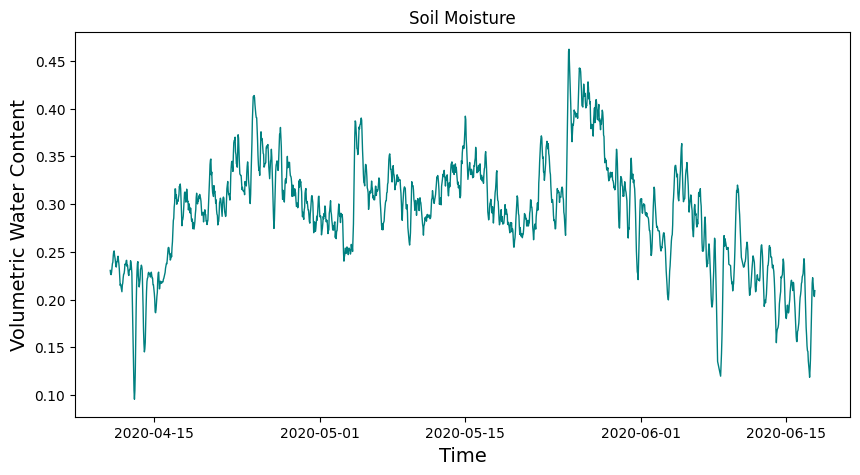

In [11]:
# Plot the obtained time series of volumetric water content
# Create a new figure and plot the data
fig, ax = plt.subplots(figsize=(10, 5))  # Set the figure size
ax.plot(df['timestamp'], df['VWC'], color='teal', linewidth=1.0)

# Set the labels for the x-axis and y-axis
ax.set_xlabel("Time", fontsize=14)
ax.set_ylabel("Volumetric Water Content", fontsize=14)

# Set the title of the plot
ax.set_title('Soil Moisture')

# Show the plot
plt.show()


### Sensing depth and soil water storage

Estimate the [`sensing_depth()`](https://soilwater.github.io/crnpy/reference/#crnpy.crnpy.sensing_depth)  at which 86 % of the neutrons probes the soil profile, and estiamte the soil water [`storage()`](https://soilwater.github.io/crnpy/reference/#crnpy.crnpy.storage) of the top 50 cm using and exponential filter.

In [12]:
# Estimate sensing depth
df['sensing_depth'] = crnpy.sensing_depth(df['VWC'], df['barometric_pressure_Avg'], df['barometric_pressure_Avg'].mean(), bulk_density=1.33, Wlat=lattice_water, method = "Franz_2012")
print(f"Average sensing depth: {np.round(df['sensing_depth'].mean(),2)} cm")


Average sensing depth: 15.84 cm


In [13]:
# Compute the storage using the exponential filter
surface, subsurface = crnpy.storage(df['VWC'], T=1, Z_surface=150, Z_subsurface=350)
df['storage'] = np.sum([surface, subsurface], axis=0)


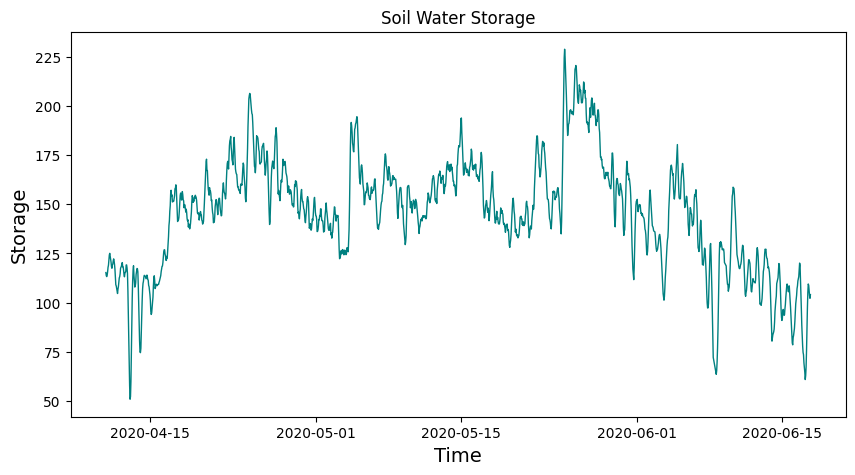

In [14]:
# Plot the obtained time series of soil water storage
# Create a new figure and plot the data
fig, ax = plt.subplots(figsize=(10, 5))  # Set the figure size
ax.plot(df['timestamp'], df['storage'], color='teal', linewidth=1.0)

# Set the labels for the x-axis and y-axis
ax.set_xlabel("Time", fontsize=14)
ax.set_ylabel("Storage", fontsize=14)

# Set the title of the plot
ax.set_title('Soil Water Storage')

# Show the plot
plt.show()
